# A Naive approach of using Isolation Forest on server data 1

Importing necessary libraries
- Pandas for dataframe
- matplotlib for plotting data
- skelrean for importing isolation forest module from scipy library
- datetime for faking timestamp
- plotly for dynamically looking/plotting at the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from datetime import datetime
import plotly.express as px

In [ ]:
# server1 = pd.read_csv('system_1.csv')     
# print(server1[['timestamp','load-1m', 'sys-thermal', 'cpu-user']].head())
# print()
# print()

In [ ]:
server1 = pd.read_csv('system_1.csv')                                             # read the csv file
start_time = datetime(2023, 10, 29, 0, 0, 0)                                      # lets assume data starts coming from this time
time_range = pd.date_range(start=start_time, periods=len(server1), freq='30S')   
server1['timestamp'] = time_range                                                 # adding time to data after every 30 from that date
print(server1)

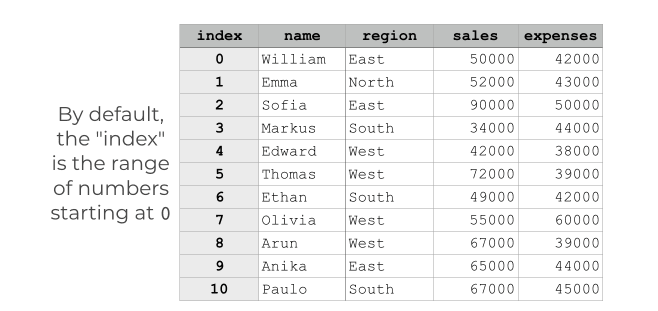
- By default, if we don’t specify another index in some way, every DataFrame has an index like this.
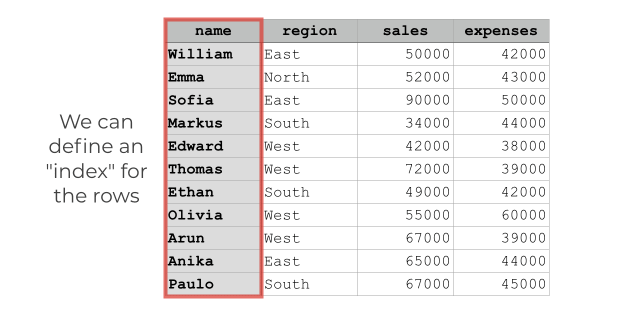
- Once we do this, we can reference rows by the index value (i.e., the “label”) associated with the particular row.
*Another Example - 
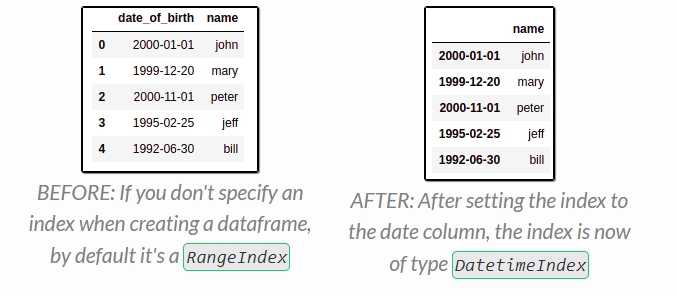
[Dataframe.set_index(keys, ....) Documentation Here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html)
Here, 
- 'timestamp': This specifies that the column named 'timestamp' in the DataFrame should be used as the new index.
- inplace: True, Whether to modify the DataFrame rather than creating a new one.

In [ ]:
server1.set_index('timestamp', inplace=True)

# taking the 'Hourly' mean of data to put on the timestamp column of another dataframe 'resampled_server1'
resampled_server1 = server1.resample('H').mean()

# Resetting the index to move the timestamp back to a column
resampled_server1.reset_index(inplace=True)

resampled_server1

In [ ]:
server1.info()
# Now, every data is either float or int and there is no null value

* [Turn thr hour into datetime format](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.hour.html)

In [ ]:
resampled_server1['hour'] = resampled_server1.timestamp.dt.hour

- Added a column named weekday where the data shows on a weekday basis

In [ ]:
resampled_server1['weekday'] = pd.Categorical(resampled_server1.timestamp.dt.strftime('%A'), 
                                              categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

## How every column looks on a weekly basis

In [ ]:
cols = ['load-1m', 'load-5m', 'load-15m','sys-mem-swap-total', 'sys-mem-swap-free', 'sys-mem-free','sys-mem-cache', 'sys-mem-buffered',
        'sys-mem-available','sys-mem-total', 'sys-fork-rate', 'sys-interrupt-rate', 'sys-context-switch-rate',
       'sys-thermal', 'disk-io-time', 'disk-bytes-read', 'disk-bytes-written',
       'disk-io-read', 'disk-io-write', 'cpu-iowait', 'cpu-system', 'cpu-user',
       'server-up']
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(20, 20))
axes_flat = axes.flatten()
for i, var in enumerate(cols):
    # Group by 'weekday', calculate mean, and plot
    resampled_server1[[var, 'weekday']].groupby('weekday').mean().plot(ax=axes_flat[i])
    axes_flat[i].set_title(var)

# Hide the empty subplots
for i in range(len(cols), 24):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

## How every column looks on a daily basis

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(20, 20))
axes_flat = axes.flatten()
for i, var in enumerate(cols):
    # Group by 'weekday', calculate mean, and plot
    resampled_server1[[var, 'hour']].groupby('hour').mean().plot(ax=axes_flat[i])
    axes_flat[i].set_title(var)

# Hide the empty subplots
for i in range(len(cols), 24):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# same graph 
resampled_server1[['load-5m', 'hour']].groupby('hour').mean().plot()

# For a better view, I used the plotly.express library

In [ ]:
fig = px.line(resampled_server1.reset_index(), x = 'timestamp', y='load-5m', title = 'server_data')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## To check if the 'load-5m' column has any pattern like on daily basis of the week
## example: the mean of every Friday and the mean of every Sunday shows same pattern

In [ ]:
resampled_server1.groupby(['hour', 'weekday']).mean()['load-5m'].unstack().plot()

In [ ]:
resampled_server1.groupby(['hour', 'weekday']).mean()['load-15m'].unstack().plot()

In [ ]:
resampled_server1[['disk-io-write', 'hour']].groupby('hour').mean().plot()

In [ ]:
fig = px.line(resampled_server1.reset_index(), x = 'timestamp', y='load-1m', title = 'server_data')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

- Turning the 'day' column as datetime format as we want to work with only int and float data

In [ ]:
resampled_server1['day'] = resampled_server1.timestamp.dt.weekday

In [ ]:
resampled_server1

### We will be using Isolation Forest on df_final dataframe, where 'timestamp' and 'weekday' column is not present

In [ ]:
df_final = resampled_server1.drop(['timestamp', 'weekday'], axis=1 )

- 'contamination=.008, max_samples=0.8, n_estimators=1000' these are the hyperparameter that can be tuned
- [Learn more about it here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

#Training the model

In [ ]:
model = IsolationForest(contamination=.008, max_samples=0.8, n_estimators=1000)
model.fit(df_final.values)

### Adding a column to resampled_server1 dataframe 'outliers' where 
- Model predicts a value on the df_final data frame, it returns -1 if that point is an outlier, otherwise 1
- If Model assume -1, we put 'Yes' otherwise 'No' on the 'outliers' column of resampled_server1 dataframe

In [ ]:
resampled_server1['outliers'] = pd.Series(model.predict(df_final.values)).apply(lambda x: 'yes' if (x == -1) else 'no')

In [ ]:
resampled_server1.query('outliers=="yes"')

# Plotting the outliers points using Plotly

In [ ]:
# To Plot Predictions
fig = px.scatter(resampled_server1, x='timestamp', y='load-1m', color='outliers', hover_data=['weekday', 'hour'])
fig.update_xaxes(rangeslider_visible = True,)
fig.show()

# Plotting using more than one variables (columns/features)

In [ ]:
# To Plot Predictions
fig = px.scatter(resampled_server1, x='timestamp',y=['load-1m', 'load-5m', 'load-15m', 'server-up'], color='outliers', hover_data=['weekday', 'hour'])
fig.update_xaxes(rangeslider_visible = True,)
fig.show()